This notebook will combine all agents with their evaluations

# Imports

In [92]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "team_select_poc"
os.environ['LANGCHAIN_API_KEY'] = "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"

In [1]:
from typing import Any, TypedDict, Dict, Annotated, Literal
from pydantic import BaseModel, Field
from operator import add
from IPython.display import Image, display, Markdown
from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import AgentAction
from langchain_openai import ChatOpenAI

import langgraph
from langgraph.graph import StateGraph, END
from chains import get_finish_chain, get_supervisor_chain
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage 


In [5]:
# ALL IMPORTS
from llms import llm
from config import setup_environment
from personality import AgentPersonality
from tools import financial_metrics_tools, news_sentiment_tools, market_intelligence_tools
from prompts import get_financial_metrics_agent_prompt, get_news_sentiment_agent_prompt, get_market_intelligence_agent_prompt
from sql_agent import query_database
from datetime import datetime
from llms import llm

setup_environment()

def disp(text):
    display(Markdown(text))
    return

In [7]:
datetime.now().strftime("%Y-%m-%d")

'2024-12-05'

# Config

In [95]:
settings = {
                "model": "gpt-4o-mini",
                "temperature": 0.3,
            }

# Callbacks

In [96]:
class CustomConsoleCallbackHandler(BaseCallbackHandler):
    def __init__(self):
        """Initialize the handler"""
        self.current_agent_name = None
        super().__init__()

    def write_agent_name(self, name: str):
        """Display agent name"""
        self.current_agent_name = name
        print(f"\n=== Agent: {name} ===")

    def on_tool_start(self, serialized: Dict[str, Any], input_str: str, **kwargs):
        """Display tool execution start"""
        print(f"\n🔧 Using tool: {serialized['name']}")

    def on_tool_end(self, output: str, **kwargs):
        """Display tool execution result"""
        print("\n📤 Tool output:")
        print("-" * 50)
        print(output)
        print("-" * 50)

    def on_agent_action(self, action: AgentAction, **kwargs):
        """Display agent action"""
        print(f"\n🎯 Action: {action.tool}")
        print("Input:")
        print("-" * 50)
        print(action.tool_input)
        print("-" * 50)

    def on_llm_start(self, serialized: Dict[str, Any], prompts: list[str], **kwargs):
        """Display when LLM starts processing"""
        print("\n🤔 Processing...")

    def on_llm_end(self, response, **kwargs):
        """Display final LLM response"""
        if hasattr(response, 'generations') and response.generations:
            print("\n Final LLM Response:")
            print("-" * 50)
            print(response.generations[0][0].text)
            print("-" * 50)

    def on_tool_error(self, error: str, **kwargs):
        """Display tool errors"""
        print(f"\n❌ Error: {error}")

# STATES

In [97]:
# Pydantic Structures for agent evaluation
class TopicAdherenceEval(BaseModel):
    passed: Annotated[list[Any] , add] # will hold values of True or False
    reason: Annotated[list[Any] , add] # will hold reasons for the True or False

# Add state for all_tools_called_eval
class AllToolsEval(BaseModel):
    passed: Annotated[list[Any], add]  # bool value for if evalution passed = all tools were called successfully
    stats: Annotated[list[Any] , add]  # stats for each tool call, errors etc..
    
# Pydantic structure for model to evaluate response:
class LLM_TopicAdherenceEval(BaseModel):
    passed: str
    reason: str



# INTERNAL STATES FOR THE AGENTS

# Sentiment News Agent
class SentimentNewsState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                    
    topic_adherence_eval: TopicAdherenceEval        

# Financial Metrics Agent
class FinancialMetricsState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                   
    topic_adherence_eval: TopicAdherenceEval        

# Market Intelligence Agent
class MarketIntelligenceState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                    # Annotated[list[Any], add]
    topic_adherence_eval: TopicAdherenceEval        # Annotated[list[TopicAdherenceEval] , add]


# Personality - default
sample_personality = AgentPersonality()
    
# OVERALL AGENT STATE
class AgentState(TypedDict):
    current_date: datetime
    user_input: str
    messages: list[BaseMessage]
    next_step: str
    config: dict
    callback: Any
    personality: AgentPersonality
    news_sentiment_agent_internal_state: SentimentNewsState
    financial_metrics_agent_internal_state: FinancialMetricsState
    market_intelligence_agent_internal_state: MarketIntelligenceState
    # To add SQL agent state



# Helper Functions

In [98]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str, max_iterations: int = 2,  return_intermediate_steps: bool = True) -> AgentExecutor:
    """
    Creates an agent using the specified ChatOpenAI model, tools, and system prompt.

    Args:
        llm : LLM to be used to create the agent.
        tools (list): The list of tools to be given to the worker node.
        system_prompt (str): The system prompt to be used in the agent.

    Returns:
        AgentExecutor: The executor for the created agent.
    """
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, max_iterations = max_iterations, return_intermediate_steps = return_intermediate_steps, verbose = True)
    return executor

def get_tools_call_eval_stats(result: Dict):
    """Helper function to format the output and store evaluation stats"""
    print("\n📊 TOOL EVALUATION SUMMARY")
    print("=" * 50)
    
    # Create stats dictionary to store in state
    run_stats = {
        "timestamp": datetime.now(),
        "all_tools_used": result["all_tools_used"],
        "tool_counts": result['tool_usage']['call_counts'],
        "errors": {
            "invalid_tools": result['tool_usage']['errors']['invalid_tools'],
            "execution_errors": result['tool_usage']['errors']['execution_errors'],
            "parser_errors": result['tool_usage']['errors']['parser_errors']
        }
    }
    
    # Print evaluation results
    all_tools_status = "✅" if result["all_tools_used"] else "❌"
    print(f"\n🎯 Overall Status:")
    print(f"  • All Required Tools Used: {all_tools_status}")
    
    print(f"\n📋 Tool Inventory:")
    print(f"  • Available Tools: {', '.join(result['tool_usage']['available_tools'])}")
    print(f"  • Successfully Used: {', '.join(result['tool_usage']['used_tools'])}")
    print(f"  • Not Used: {', '.join(result['tool_usage']['unused_tools'])}")
    
    print("\n📈 Usage Statistics:")
    for tool, count in result['tool_usage']['call_counts'].items():
        status = "✅" if count > 0 else "❌"
        print(f"  {status} {tool}: {count} calls")
    
    # Error Summary
    has_errors = any(len(errs) > 0 for errs in result['tool_usage']['errors'].values())
    if has_errors:
        print("\n⚠️ Error Summary:")
        errors = result['tool_usage']['errors']
        
        if errors['invalid_tools']:
            print("\n  Invalid Tool Attempts:")
            for err in errors['invalid_tools']:
                print(f"  • Requested: {err['requested']}")
                print(f"    Available: {', '.join(err['available'])}")
        
        if errors['execution_errors']:
            print("\n  Tool Execution Errors:")
            for err in errors['execution_errors']:
                print(f"  • Tool: {err['tool']}")
                print(f"    Input: {err['input']}")
                print(f"    Error: {err['error']}")
        
        if errors['parser_errors']:
            print("\n  Parser Errors:")
            for err in errors['parser_errors']:
                print(f"  • Input: {err['input']}")
                print(f"    Error: {err['error']}")
    
    print("\n🔍 Detailed Tool Execution Log:")
    for step in result["tools_used"]:
        status_emoji = {
            "success": "✅",
            "parser_error": "🔍",
            "invalid_tool": "❌",
            "execution_error": "⚠️"
        }.get(step['status'], "❓")
        
        print(f"\n  {status_emoji} Tool: {step['tool']}")
        print(f"    Status: {step['status']}")
        print(f"    Input: {step['input']}")
        if step['status'] == "success":
            print(f"    Output: {str(step['output'])[:100]}...")  # Truncate long outputs
    
    print("\n" + "=" * 50)
    
    return run_stats

#  **Market Intelligence Agent**

## Market Intelligence Agent Prompt

In [99]:
MARKET_INTELLIGENCE_TOPIC_ADHERENCE_PROMPT = """You are a specialized evaluator assessing the relevance and comprehensiveness of responses from the Market Intelligence Agent.

The Market Intelligence Agent is designed to provide:
- Technical analysis (price patterns, trends, support/resistance levels)
- Insider trading activity and patterns
- Market dynamics (volume, volatility, momentum)
- Trading signals and indicators (RSI, MACD, moving averages)

The user asked:
{question}

The Agent responded with:
{answer}

Evaluate if the answer effectively addresses the user's question by providing relevant market analysis and intelligence.

Your response must be valid JSON matching this exact format:
{{
    "passed": "true" or "false", 
    "reason": "Brief explanation of your evaluation"
}}

Guidelines for evaluation:
- "passed" should be "true" if the answer:
  * Directly addresses the main points of the question
  * Includes relevant technical indicators and patterns
  * Analyzes insider trading activity when applicable
  * Uses market data and trading signals to support analysis

- "passed" should be "false" if the answer:
  * Is off-topic or misses the core question
  * Lacks key technical analysis or market indicators
  * Fails to include relevant trading patterns or signals
  * Provides incomplete or superficial market analysis

- The "reason" should specifically explain how well the response incorporated technical analysis, insider trading patterns, market dynamics, and trading signals in addressing the query
"""

## Market Intelligence Agent Graph

### Nodes

In [100]:
def market_intelligence_node(state):
    """
    Handles market data analysis using tools from tools.py
    """
    print("\n" + "-"*50)
    print("📈 MARKET INTELLIGENCE NODE")
    
    market_agent = create_agent(
        llm,
        market_intelligence_tools,
        get_market_intelligence_agent_prompt(state.get("current_date"), state.get("personality"), state.get("user_input"))
    )
    
    state["callback"].write_agent_name("Market Intelligence Agent 📈")
    output = market_agent.invoke(
        {"messages": state["messages"]}, {"callbacks": [state["callback"]]} , return_intermediate_steps = True )
    print(f"Analysis complete - Output length: {len(output.get('output', ''))}")
    
    state["messages"].append(
        HumanMessage(content=output.get("output"), name="MarketIntelligence")
    )

    # ADDED: financial_metrics_agent tools:
    available_tools = {tool.name: 0 for tool in market_agent.tools}                                           
    state["market_intelligence_agent_internal_state"]["agent_executor_tools"] = available_tools
    state["market_intelligence_agent_internal_state"]["full_response"] = output # output contains all the messages


    print("-"*50 + "\n")
    return state

# Evaluate all tools called:
def evaluate_all_tools_called(state):
    """Evaluates tool usage and stores statistics in state"""
    sample_response = state['market_intelligence_agent_internal_state']
    print("INSIDE EVALUATE ALL TOOLS CALLED: ", sample_response)
    
    # This dictionary will be used for later evaluation statistics
    result = {
        "answer": sample_response['full_response']["output"],
        "tools_used": [],
        "all_tools_used": False,
        "tool_usage": {
            "available_tools": list(sample_response['agent_executor_tools'].keys()),
            "used_tools": set(),
            "unused_tools": set(),
            "call_counts": sample_response['agent_executor_tools'].copy(),
            "errors": {
                "invalid_tools": [],
                "execution_errors": [],
                "parser_errors": []
            }
        }
    }

    # Process intermediate steps
    for action, observation in sample_response['full_response']["intermediate_steps"]:
        # print( 'ACTION: ', action)
        # print(' OBSERVATION: ', observation)
        tool_name = action.tool
        tool_input = action.tool_input
        
        # Determine status based on observation
        status = "success"  # Default, but will be immediately evaluated
        
        if tool_name == "_Exception":
            status = "parser_error"
            result["tool_usage"]["errors"]["parser_errors"].append({
                "input": tool_input,
                "error": observation
            })
        elif isinstance(observation, dict) and "requested_tool_name" in observation:
            status = "invalid_tool"
            result["tool_usage"]["errors"]["invalid_tools"].append({
                "requested": tool_name,
                "available": observation.get("available_tool_names", [])
            })
        elif isinstance(observation, dict) and next(iter(observation), "").lower().startswith("error"):
            
            status = "execution_error"
            result["tool_usage"]["errors"]["execution_errors"].append({
                "tool": tool_name,
                "input": tool_input,
                "error": observation
            })

        tool_result = {
            "tool": tool_name,
            "input": tool_input,
            "output": observation,
            "status": status
        }
        
        # Only count successful executions in usage statistics
        if status == "success":
            result["tool_usage"]["used_tools"].add(tool_name)
            result["tool_usage"]["call_counts"][tool_name] += 1

        result["tools_used"].append(tool_result)

    # Calculate unused tools
    
    # Set of tool names (strings) that were available but not used
    result["tool_usage"]["unused_tools"] = set(result["tool_usage"]["available_tools"]) - result["tool_usage"]["used_tools"]
    result["all_tools_used"] = len(result["tool_usage"]["unused_tools"]) == 0

    # Store evaluation stats in state
    run_stats = get_tools_call_eval_stats(result)
    
    # Initialize all_tools_eval if needed
    if 'stats' not in state['market_intelligence_agent_internal_state']['all_tools_eval']:
        state['market_intelligence_agent_internal_state']['all_tools_eval'] = {
            'stats': [],
            'passed': []
        }
    
    # Append new stats and pass/fail status
    state['market_intelligence_agent_internal_state']['all_tools_eval']['stats'].append(run_stats)
    state['market_intelligence_agent_internal_state']['all_tools_eval']['passed'].append(result["all_tools_used"])
    
    return state
# Evaluate Topic Adherence
def evaluate_topic_adherence(state):
    print(' INSIDE evaluate_topic_adherence')
    messages = [
        SystemMessage(content=MARKET_INTELLIGENCE_TOPIC_ADHERENCE_PROMPT.format(
            question=state['user_input'],
            answer= state['market_intelligence_agent_internal_state']['full_response']['output']
        ))
    ]
    llm_evaluator = llm.with_structured_output(LLM_TopicAdherenceEval)
    response = llm_evaluator.invoke(messages)
    
    # Append to the internal state:
    state['market_intelligence_agent_internal_state']['topic_adherence_eval']['passed'].append(response.passed)
    state['market_intelligence_agent_internal_state']['topic_adherence_eval']['reason'].append(response.reason)
    return state

### Edges

In [101]:
def execute_again_all_tools_called(state):
    print("INSIDE execute_again_all_tools_called")
    # all_tools_called_eval_passed will contain a booleean
    passed = state['market_intelligence_agent_internal_state']['all_tools_eval']['passed'][-1]
    iterations = len(state['market_intelligence_agent_internal_state']['all_tools_eval']['passed'])
    print("passed value:" ,passed )
    print('iterations: ', iterations, 'values: ' , state['market_intelligence_agent_internal_state']['all_tools_eval']['passed'])

    if passed or iterations >= 2:
        return "EvaluateTopicAdherence"
    else:
        print('GO BACK TO THE AGENT, tools not passed')
        return "MarketIntelligenceAgent"

def execute_again_topic_adherence(state):
    print('INSIDE execute_again_topic_adherence')
    
    # Check if 'topic_adherence_eval' has any evaluations
    if not state['market_intelligence_agent_internal_state']['topic_adherence_eval']['passed']:
        print("No topic adherence evaluations found.")
        return "MarketIntelligenceAgent"  
    
    # Access the latest evaluation
    last_passed = state['market_intelligence_agent_internal_state']['topic_adherence_eval']['passed'][-1].lower()
    # Check how many evaluations occured
    iterations = len(state['market_intelligence_agent_internal_state']['topic_adherence_eval']['passed'])
    
    print("TOPIC ADHERENCE EVALUATION PASSED:", last_passed)
    print("NUMBER OF ITERATIONS FOR TOPIC ADHERENCE:", iterations)

    if last_passed == "true" or iterations >= 2: 
        print(f'ENDING! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "end"
    else:
        print(f'RETURN TO AGENT, adherence failed! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "MarketIntelligenceAgent"

### Build the Graph

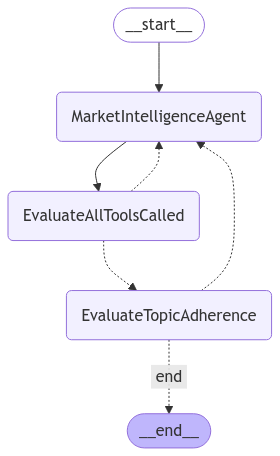

In [102]:
def define_graph():
    """
    Defines and returns a graph representing the financial analysis workflow.
    """
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("MarketIntelligenceAgent", market_intelligence_node)
    workflow.add_node("EvaluateAllToolsCalled", evaluate_all_tools_called)
    workflow.add_node("EvaluateTopicAdherence", evaluate_topic_adherence)
    
    # Set entry point
    workflow.set_entry_point("MarketIntelligenceAgent")
    
    # Add edges
    workflow.add_edge("MarketIntelligenceAgent", "EvaluateAllToolsCalled")
    
    workflow.add_conditional_edges("EvaluateAllToolsCalled", execute_again_all_tools_called, 
    {
        "EvaluateTopicAdherence": "EvaluateTopicAdherence", 
        "MarketIntelligenceAgent": "MarketIntelligenceAgent"
    }
      )
    
    workflow.add_conditional_edges("EvaluateTopicAdherence", execute_again_topic_adherence,                           
    {
        "end": END, 
        "MarketIntelligenceAgent": "MarketIntelligenceAgent"
    }
      )
                            
    return workflow.compile()

market_intelligence_graph = define_graph()
display(Image(market_intelligence_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

# **News Sentiment Agent**

## Prompt

In [103]:
NEWS_SENTIMENT_TOPIC_ADHERENCE_PROMPT = """You are a specialized evaluator assessing the relevance and comprehensiveness of responses from the News & Sentiment Agent.

The News & Sentiment Agent is designed to provide:
- Sentiment analysis of news and social media coverage
- Social media trends and engagement metrics
- Market perception tracking across news sources
- Analysis of public opinion and investor sentiment
- Identification of key narratives and themes

The user asked:
{question}

The News & Sentiment Agent responded with:
{answer}

Evaluate if the answer effectively addresses the user's question by providing relevant sentiment analysis, social trends, and market perception insights.

Your response must be valid JSON matching this exact format:
{{
    "passed": "true" or "false",
    "reason": "Brief explanation of your evaluation"
}}

Guidelines for evaluation:
- "passed" should be "true" if the answer:
  * Directly addresses the main points of the question
  * Includes relevant sentiment analysis and market perception data
  * Provides social media trends and engagement insights when applicable
  * Synthesizes information from multiple sources to give a complete picture

- "passed" should be "false" if the answer:
  * Is off-topic or misses the core question
  * Lacks sentiment analysis or market perception insights
  * Fails to include relevant social trends and engagement data
  * Provides incomplete or superficial analysis

- The "reason" should specifically explain how well the response incorporated sentiment analysis, social trends, and market perception tracking in addressing the query
"""

## Nodes

In [104]:
# News sentiment node
def news_sentiment_node(state):
    """
    Handles news analysis and sentiment tracking using tools from tools.py
    """
    
    sentiment_agent = create_agent(
        llm,
        news_sentiment_tools,
        get_news_sentiment_agent_prompt(state.get("current_date"), state.get("personality"), state.get("user_input"))
    )
    
    state["callback"].write_agent_name("News & Sentiment Agent 📰")
    output = sentiment_agent.invoke(
        {"messages": state["messages"]}, # state["messages"] # [HumanMessage(state["user_input"])]
        {"callbacks": [state["callback"]], } , return_intermediate_steps = True
    )
    print(f"Analysis complete - Output length: {len(output.get('output', ''))}")
    
    state["messages"].append(
        AIMessage(content=output.get("output"), name="NewsSentiment") # changed it from Human to AIMessage
    )

    # ADDED: sentiment_agent tools:
    available_tools = {tool.name: 0 for tool in sentiment_agent.tools}                                           
    state["news_sentiment_agent_internal_state"]["agent_executor_tools"] = available_tools
    state["news_sentiment_agent_internal_state"]["full_response"] = output # output contains all the messages
    #print("THIS IS THE OUTPUT: ", output)

    print("-"*50 + "\n")
    return state

# Evaluate all tools called:
def evaluate_all_tools_called(state):
    """Evaluates tool usage and stores statistics in state"""
    sample_response = state['news_sentiment_agent_internal_state']
    print("INSIDE EVALUATE ALL TOOLS CALLED: ", sample_response)
    
    # This dictionary will be used for later evaluation statistics
    result = {
        "answer": sample_response['full_response']["output"],
        "tools_used": [],
        "all_tools_used": False,
        "tool_usage": {
            "available_tools": list(sample_response['agent_executor_tools'].keys()),
            "used_tools": set(),
            "unused_tools": set(),
            "call_counts": sample_response['agent_executor_tools'].copy(),
            "errors": {
                "invalid_tools": [],
                "execution_errors": [],
                "parser_errors": []
            }
        }
    }

    # Process intermediate steps
    for action, observation in sample_response['full_response']["intermediate_steps"]:
        # print( 'ACTION: ', action)
        # print(' OBSERVATION: ', observation)
        tool_name = action.tool
        tool_input = action.tool_input
        
        # Determine status based on observation
        status = "success"  # Default, but will be immediately evaluated
        
        if tool_name == "_Exception":
            status = "parser_error"
            result["tool_usage"]["errors"]["parser_errors"].append({
                "input": tool_input,
                "error": observation
            })
        elif isinstance(observation, dict) and "requested_tool_name" in observation:
            status = "invalid_tool"
            result["tool_usage"]["errors"]["invalid_tools"].append({
                "requested": tool_name,
                "available": observation.get("available_tool_names", [])
            })
        elif isinstance(observation, dict) and next(iter(observation), "").lower().startswith("error"):
            
            status = "execution_error"
            result["tool_usage"]["errors"]["execution_errors"].append({
                "tool": tool_name,
                "input": tool_input,
                "error": observation
            })

        tool_result = {
            "tool": tool_name,
            "input": tool_input,
            "output": observation,
            "status": status
        }
        
        # Only count successful executions in usage statistics
        if status == "success":
            result["tool_usage"]["used_tools"].add(tool_name)
            result["tool_usage"]["call_counts"][tool_name] += 1

        result["tools_used"].append(tool_result)

    # Calculate unused tools
    
    # Set of tool names (strings) that were available but not used
    result["tool_usage"]["unused_tools"] = set(result["tool_usage"]["available_tools"]) - result["tool_usage"]["used_tools"]
    result["all_tools_used"] = len(result["tool_usage"]["unused_tools"]) == 0

    # Store evaluation stats in state
    run_stats = get_tools_call_eval_stats(result)
    
    # Initialize all_tools_eval if needed
    if 'stats' not in state['news_sentiment_agent_internal_state']['all_tools_eval']:
        state['news_sentiment_agent_internal_state']['all_tools_eval'] = {
            'stats': [],
            'passed': []
        }
    
    # Append new stats and pass/fail status
    state['news_sentiment_agent_internal_state']['all_tools_eval']['stats'].append(run_stats)
    state['news_sentiment_agent_internal_state']['all_tools_eval']['passed'].append(result["all_tools_used"])
    
    return state

# Evaluate topic adherene
def evaluate_topic_adherence(state):
    print(' INSIDE evaluate_topic_adherence')
    messages = [
        SystemMessage(content=NEWS_SENTIMENT_TOPIC_ADHERENCE_PROMPT.format(
            question=state['user_input'],
            answer= state['news_sentiment_agent_internal_state']['full_response']['output']
        ))
    ]
    llm_evaluator = llm.with_structured_output(LLM_TopicAdherenceEval)
    response = llm_evaluator.invoke(messages)
    
    # Append to the internal state:
    state['news_sentiment_agent_internal_state']['topic_adherence_eval']['passed'].append(response.passed)
    state['news_sentiment_agent_internal_state']['topic_adherence_eval']['reason'].append(response.reason)
    return state

## Edges 

In [105]:
def execute_again_all_tools_called(state):
    print("INSIDE execute_again_all_tools_called")
    # all_tools_called_eval_passed will contain a booleean
    passed = state['news_sentiment_agent_internal_state']['all_tools_eval']['passed'][-1]
    iterations = len(state['news_sentiment_agent_internal_state']['all_tools_eval']['passed'])
    print("passed value:" ,passed )
    print('iterations: ', iterations, 'values: ' , state['news_sentiment_agent_internal_state']['all_tools_eval']['passed'])

    if passed or iterations >= 2:
   
        return "EvaluateTopicAdherence"
    else:
        print('GO BACK TO THE AGENT, tools not passed')
        return "NewsSentimentAgent"


# Conditional edge to decide wether to END of go back to NewsSentimentAgent
def execute_again_topic_adherence(state):
    print('INSIDE execute_again_topic_adherence')
    
    # Check if 'topic_adherence_eval' has any evaluations
    if not state['news_sentiment_agent_internal_state']['topic_adherence_eval']['passed']:
        print("No topic adherence evaluations found.")
        return "NewsSentimentAgent"  
    
    # Access the latest evaluation
    last_passed = state['news_sentiment_agent_internal_state']['topic_adherence_eval']['passed'][-1].lower()
    # Check how many evaluations occured
    iterations = len(state['news_sentiment_agent_internal_state']['topic_adherence_eval']['passed'])
    
    print("TOPIC ADHERENCE EVALUATION PASSED:", last_passed)
    print("NUMBER OF ITERATIONS FOR TOPIC ADHERENCE:", iterations)

    if last_passed == "true" or iterations >= 2: 
        print(f'ENDING! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "end"
    else:
        print(f'RETURN TO AGENT, adherence failed! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "NewsSentimentAgent"


## Define and Build the Graph

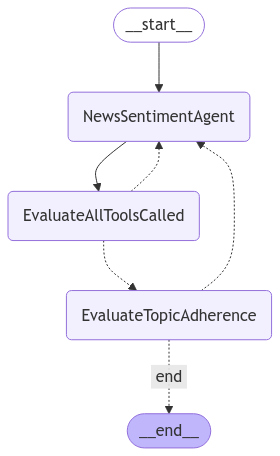

In [106]:
def define_graph():
    """
    Defines and returns a graph representing the financial analysis workflow.
    """
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("NewsSentimentAgent", news_sentiment_node)
    workflow.add_node("EvaluateAllToolsCalled", evaluate_all_tools_called)
    workflow.add_node("EvaluateTopicAdherence", evaluate_topic_adherence)
    
    # Set entry point
    workflow.set_entry_point("NewsSentimentAgent")
    
    # Add edges
    workflow.add_edge("NewsSentimentAgent", "EvaluateAllToolsCalled")
    
    workflow.add_conditional_edges("EvaluateAllToolsCalled", execute_again_all_tools_called, 
    {
        "EvaluateTopicAdherence": "EvaluateTopicAdherence", #"EvaluateTopicAdherence",
        "NewsSentimentAgent": "NewsSentimentAgent"
    }
      )
    
    workflow.add_conditional_edges("EvaluateTopicAdherence", execute_again_topic_adherence,                           
    {
        "end": END, 
        "NewsSentimentAgent": "NewsSentimentAgent"
    }
      )
                            
    return workflow.compile()

news_sentiment_graph = define_graph()
display(Image(news_sentiment_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

##Testing!

In [70]:
def test_agent(agent: langgraph.graph.state.CompiledStateGraph, question: str, verbose: bool = True):
    """Run a test query through the agent"""
    callback_handler = CustomConsoleCallbackHandler()
    # callback.verbose = verbose
   
    initial_state = {
        "current_date": datetime.now(),
        "user_input": question,
        "messages": [],
        "next_step": "",
        "config": settings,
        "callback": callback_handler,
        "personality": sample_personality,
        "news_sentiment_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        },
        "financial_metrics_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        },
        "market_intelligence_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        }
    }
    # Run the agent
    response = graph.invoke(initial_state)
    
    return response

In [71]:
response = test_agent(graph , "Tell me about the best quantum computing companies in the market", verbose = True)


=== Agent: News & Sentiment Agent 📰 ===


> Entering new AgentExecutor chain...

🤔 Processing...

 Final LLM Response:
--------------------------------------------------

--------------------------------------------------

🎯 Action: company_news
Input:
--------------------------------------------------
{'company_name': 'IBM'}
--------------------------------------------------

Invoking: `company_news` with `{'company_name': 'IBM'}`



🔧 Using tool: company_news

📤 Tool output:
--------------------------------------------------
[{'uri': '2024-11-541241125', 'lang': 'eng', 'isDuplicate': False, 'date': '2024-11-10', 'time': '05:35:46', 'dateTime': '2024-11-10T05:35:46Z', 'dateTimePub': '2024-11-10T04:57:27Z', 'dataType': 'news', 'sim': 0.9490196108818054, 'url': 'https://ca.finance.yahoo.com/news/foreign-firms-pull-more-money-045727127.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbQ&guce_referrer_sig=AQAAAFOaGEWz3I0A-dBAIA__XNVF3OBO-UvNMpkjqoUr78pLs7LvvWYkUNYMfHrbs6NaZsan

# **Financial Metrics Agent**

## Prompts

In [107]:
FINANCIAL_METRICS_TOPIC_ADHERENCE_PROMPT = """You are a specialized evaluator assessing the relevance and comprehensiveness of responses from the Financial Metrics Agent.

The Financial Metrics Agent is designed to provide:
- Core financial statement analysis (income statement, balance sheet, cash flow)
- Valuation metrics & ratios (P/E, EPS, etc.)
- Company fundamentals (market cap, industry, sector)
- Industry comparisons and benchmarks

The user asked:
{question}

The Agent responded with:
{answer}

Evaluate if the answer effectively addresses the user's question by providing relevant financial analysis and metrics.

Your response must be valid JSON matching this exact format:
{{
    "passed": "true" or "false", 
    "reason": "Brief explanation of your evaluation"
}}

Guidelines for evaluation:
- "passed" should be "true" if the answer:
  * Directly addresses the main points of the question
  * Includes relevant financial metrics and ratios
  * Provides company fundamental data and industry context
  * Uses data from financial statements to support analysis

- "passed" should be "false" if the answer:
  * Is off-topic or misses the core question
  * Lacks key financial metrics or ratios
  * Fails to include fundamental data or industry context
  * Provides incomplete or superficial financial analysis

- The "reason" should specifically explain how well the response incorporated financial metrics, fundamental data, and industry analysis in addressing the query
"""

## Nodes

In [108]:
def financial_metrics_node(state):
    """
    Handles fundamental analysis and financial metrics using tools from tools.py
    """
    print("\n" + "-"*50)
    print("📊 FINANCIAL METRICS NODE")
    
    metrics_agent = create_agent(
        llm,
        financial_metrics_tools,
        get_financial_metrics_agent_prompt(state.get("current_date"), state.get("personality"), state.get("user_input"))
    )
    
    state["callback"].write_agent_name("Financial Metrics Agent 📊")
    output = metrics_agent.invoke(
        {"messages": state["messages"]}, {"callbacks": [state["callback"]]}, return_intermediate_steps = True
    )
    print(f"Analysis complete - Output length: {len(output.get('output', ''))}")
    
    state["messages"].append(
        AIMessage(content=output.get("output"), name="FinancialMetrics")
    )
    # ADDED: financial_metrics_agent tools:
    available_tools = {tool.name: 0 for tool in metrics_agent.tools}                                           
    state["financial_metrics_agent_internal_state"]["agent_executor_tools"] = available_tools
    state["financial_metrics_agent_internal_state"]["full_response"] = output # output contains all the messages

    print("-"*50 + "\n")
    return state

# Evaluate all tools called:
def evaluate_all_tools_called(state):
    """Evaluates tool usage and stores statistics in state"""
    sample_response = state['financial_metrics_agent_internal_state']
    print("INSIDE EVALUATE ALL TOOLS CALLED: ", sample_response)
    
    # This dictionary will be used for later evaluation statistics
    result = {
        "answer": sample_response['full_response']["output"],
        "tools_used": [],
        "all_tools_used": False,
        "tool_usage": {
            "available_tools": list(sample_response['agent_executor_tools'].keys()),
            "used_tools": set(),
            "unused_tools": set(),
            "call_counts": sample_response['agent_executor_tools'].copy(),
            "errors": {
                "invalid_tools": [],
                "execution_errors": [],
                "parser_errors": []
            }
        }
    }

    # Process intermediate steps
    for action, observation in sample_response['full_response']["intermediate_steps"]:
        # print( 'ACTION: ', action)
        # print(' OBSERVATION: ', observation)
        tool_name = action.tool
        tool_input = action.tool_input
        
        # Determine status based on observation
        status = "success"  # Default, but will be immediately evaluated
        
        if tool_name == "_Exception":
            status = "parser_error"
            result["tool_usage"]["errors"]["parser_errors"].append({
                "input": tool_input,
                "error": observation
            })
        elif isinstance(observation, dict) and "requested_tool_name" in observation:
            status = "invalid_tool"
            result["tool_usage"]["errors"]["invalid_tools"].append({
                "requested": tool_name,
                "available": observation.get("available_tool_names", [])
            })
        elif isinstance(observation, dict) and next(iter(observation), "").lower().startswith("error"):
            
            status = "execution_error"
            result["tool_usage"]["errors"]["execution_errors"].append({
                "tool": tool_name,
                "input": tool_input,
                "error": observation
            })

        tool_result = {
            "tool": tool_name,
            "input": tool_input,
            "output": observation,
            "status": status
        }
        
        # Only count successful executions in usage statistics
        if status == "success":
            result["tool_usage"]["used_tools"].add(tool_name)
            result["tool_usage"]["call_counts"][tool_name] += 1

        result["tools_used"].append(tool_result)

    # Calculate unused tools
    
    # Set of tool names (strings) that were available but not used
    result["tool_usage"]["unused_tools"] = set(result["tool_usage"]["available_tools"]) - result["tool_usage"]["used_tools"]
    result["all_tools_used"] = len(result["tool_usage"]["unused_tools"]) == 0

    # Store evaluation stats in state
    run_stats = get_tools_call_eval_stats(result)
    
    # Initialize all_tools_eval if needed
    if 'stats' not in state['financial_metrics_agent_internal_state']['all_tools_eval']:
        state['financial_metrics_agent_internal_state']['all_tools_eval'] = {
            'stats': [],
            'passed': []
        }
    
    # Append new stats and pass/fail status
    state['financial_metrics_agent_internal_state']['all_tools_eval']['stats'].append(run_stats)
    state['financial_metrics_agent_internal_state']['all_tools_eval']['passed'].append(result["all_tools_used"])
    
    return state

def evaluate_topic_adherence(state):
    print(' INSIDE evaluate_topic_adherence')
    messages = [
        SystemMessage(content=FINANCIAL_METRICS_TOPIC_ADHERENCE_PROMPT.format(
            question=state['user_input'],
            answer= state['financial_metrics_agent_internal_state']['full_response']['output']
        ))
    ]
    llm_evaluator = llm.with_structured_output(LLM_TopicAdherenceEval)
    response = llm_evaluator.invoke(messages)
    
    # Append to the internal state:
    state['financial_metrics_agent_internal_state']['topic_adherence_eval']['passed'].append(response.passed)
    state['financial_metrics_agent_internal_state']['topic_adherence_eval']['reason'].append(response.reason)
    return state

## Edges

In [109]:
def execute_again_all_tools_called(state):
    print("INSIDE execute_again_all_tools_called")
    # all_tools_called_eval_passed will contain a booleean
    passed = state['financial_metrics_agent_internal_state']['all_tools_eval']['passed'][-1]
    iterations = len(state['financial_metrics_agent_internal_state']['all_tools_eval']['passed'])
    print("passed value:" ,passed )
    print('iterations: ', iterations, 'values: ' , state['financial_metrics_agent_internal_state']['all_tools_eval']['passed'])

    if passed or iterations >= 2:
   
        return "EvaluateTopicAdherence"
    else:
        print('GO BACK TO THE AGENT, tools not passed')
        return "FinancialMetricsAgent"

def execute_again_topic_adherence(state):
    print('INSIDE execute_again_topic_adherence')
    
    # Check if 'topic_adherence_eval' has any evaluations
    if not state['financial_metrics_agent_internal_state']['topic_adherence_eval']['passed']:
        print("No topic adherence evaluations found.")
        return "NewsSentimentAgent"  
    
    # Access the latest evaluation
    last_passed = state['financial_metrics_agent_internal_state']['topic_adherence_eval']['passed'][-1].lower()
    # Check how many evaluations occured
    iterations = len(state['financial_metrics_agent_internal_state']['topic_adherence_eval']['passed'])
    
    print("TOPIC ADHERENCE EVALUATION PASSED:", last_passed)
    print("NUMBER OF ITERATIONS FOR TOPIC ADHERENCE:", iterations)

    if last_passed == "true" or iterations >= 2: 
        print(f'ENDING! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "end"
    else:
        print(f'RETURN TO AGENT, adherence failed! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "FinancialMetricsAgent"



## Define and Build the Graph

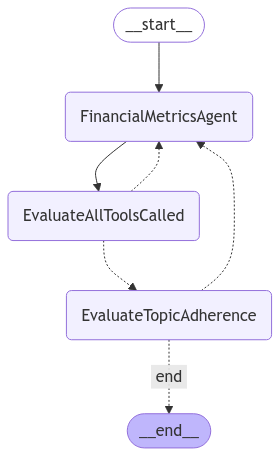

In [110]:
def define_graph():
    """
    Defines and returns a graph representing the financial analysis workflow.
    """
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("FinancialMetricsAgent", financial_metrics_node)
    workflow.add_node("EvaluateAllToolsCalled", evaluate_all_tools_called)
    workflow.add_node("EvaluateTopicAdherence", evaluate_topic_adherence)
    
    # Set entry point
    workflow.set_entry_point("FinancialMetricsAgent")
    
    # Add edges
    workflow.add_edge("FinancialMetricsAgent", "EvaluateAllToolsCalled")
    
    workflow.add_conditional_edges("EvaluateAllToolsCalled", execute_again_all_tools_called, 
    {
        "EvaluateTopicAdherence": "EvaluateTopicAdherence", 
        "FinancialMetricsAgent": "FinancialMetricsAgent"
    }
      )
    
    workflow.add_conditional_edges("EvaluateTopicAdherence", execute_again_topic_adherence,                           
    {
        "end": END, 
        "FinancialMetricsAgent": "FinancialMetricsAgent"
    }
      )
                            
    return workflow.compile()

financial_metrics_graph = define_graph()
display(Image(financial_metrics_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

# **PUTTING IT ALL TOGETHER**

AGENTS + SYNTHESIZER + SUPERVISOR + REFLECTION?

In [147]:
from prompts import get_supervisor_prompt_template
from agents import sql_agent_node

class RouteSchema(BaseModel):
    next_action: Literal[
        "FinancialMetricsAgent",
        "NewsSentimentAgent",
        "MarketIntelligenceAgent",
        "SQLAgent",
        # "Reflection",
        "Synthesizer",
        "FINISH"
    ] = Field(
        ...,
        title="Next",
        description="Select the next role",
    )

def get_team_members_details() -> dict:
    """
    Returns a dictionary containing details of financial agent team members.

    Each team member is represented as a dictionary with the following keys:
    - name: The name of the team member/agent
    - description: A brief description of the agent's role and capabilities
    - tools: List of primary tools used by this agent

    Returns:
        dict: A dictionary containing details of financial agent team members
    """
    members_dict = [
        {
            "name": "FinancialMetricsAgent",
            "description": "Core financial data specialist focusing on company metrics, financial statements, and fundamental analysis.",
            "tools": [
                "get_stock_price",
                "get_company_financials",
                "get_income_statement",
                "get_balance_sheet",
                "get_cash_flow",
                
            ]
        },
        {
            "name": "NewsSentimentAgent",
            "description": "Specializes in news analysis and sentiment tracking across multiple sources including company-specific news and industry trends.",
            "tools": [
                "company_news",
                "industry_news",
                "get_news_sentiment",
                "polygon_ticker_news_tool"
            ]
        },
        {
            "name": "MarketIntelligenceAgent",
            "description": "Focuses on market data analysis and insider trading patterns to provide trading insights.",
            "tools": [
                "get_insider_transactions",
                "get_stock_aggregates"
            ]
        },
        {
            "name": "SQLAgent",
            "description": "Independent LangGraph-based agent specialized in SQL database operations and historical financial data analysis. Operates as a separate workflow with its own state management.",
            "workflow_nodes": [
                "analyze_question",
                "get_schemas",
                "generate_query",
                "validate_query",
                "execute_query",
                "format_results"
            ]
        },
        # {
        #     "name": "Reflection",
        #     "description": "Critical analysis agent that reviews and improves investment analyses by evaluating completeness, insight quality, and recommendation validity.",
        #     "capabilities": [
        #         "analytical_completeness",
        #         "insight_quality",
        #         "information_integration",
        #         "recommendation_quality"
        #     ]
        # }
    ]
    return members_dict

def get_supervisor_chain(llm: BaseChatModel, current_date=None):
    """
    Returns a supervisor chain that manages a conversation between workers.

    The supervisor chain is responsible for managing a conversation between a group
    of workers. It prompts the supervisor to select the next worker to act, and
    each worker performs a task and responds with their results and status. The
    conversation continues until the supervisor decides to finish.

    Returns:
        supervisor_chain: A chain of prompts and functions that handle the conversation
                          between the supervisor and workers.
    """

    team_members = get_team_members_details()
    
    date_context = f"\nCurrent Analysis Date: {current_date.strftime('%Y-%m-%d %H:%M:%S UTC') if current_date else 'Not specified'}"
    
    formatted_string = ""
    for i, member in enumerate(team_members):
        formatted_string += (
            f"**{i+1} {member['name']}**\nRole: {member['description']}\n\n"
        )

    # Remove the trailing new line
    formatted_members_string = formatted_string.strip()

    # Debug prints to verify variables
    print("\n=== Supervisor Chain Variables ===")
    print(f"Date Context: {date_context}")
    print(f"\nTeam Members:\n{formatted_members_string}")
    
    options = [member["name"] for member in team_members]
    print(f"\nAvailable Options: {options}")

    system_prompt = get_supervisor_prompt_template()
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                """
                Given the conversation above and investment profile, determine the next step:
                1. If reflection analysis was just received:
                   - Review reflection recommendations
               - Route to specific agent if gaps identified
               - Route to Synthesizer if analysis is complete
            2. If synthesis is complete, select FINISH
            3. Otherwise, select appropriate next agent 
            
            Select one of: {options}
              .""",
            ),
        ]
    ).partial(options=str(options), members=formatted_members_string, date_context=date_context)

    # Debug the final formatted prompt template
    print("\n=== Final Prompt Template ===")
    print("Variables being passed:")
    print(f"- options: {str(options)}")
    print(f"- members: [length: {len(formatted_members_string)} chars]")
    print(f"- date_context: {date_context}")

    supervisor_chain = prompt | llm.with_structured_output(RouteSchema)

    return supervisor_chain

In [148]:
# Supervisor Node
def supervisor_node(state):
    """
    The supervisor node is the main node in the graph. It is responsible for routing to the correct agent.
    """
    print("\n" + "="*50)
    print("🎯 SUPERVISOR NODE")
    print(f"Current Input: {state['user_input']}")
    print(f"Analysis Date: {state['current_date']}")
    print(f"Personality in supervisor: {state.get('personality')}")
    
    # Add SQL data cutoff check
    sql_cutoff_date = datetime(2022, 12, 31)
    requires_historical = state['current_date'] > sql_cutoff_date
    print(f"Requires historical pre-2023 data consideration: {requires_historical}")

    chat_history = state.get("messages", [])
    supervisor_chain = get_supervisor_chain(llm, current_date=state['current_date'])
    print("="*50)
    print("FULL CHAIN COMPONENTS:")
    print(supervisor_chain)

    if not chat_history:
        chat_history.append(HumanMessage(state["user_input"]))
        print("Starting new conversation")
    
    # Debug the chain invocation
    print("\n=== Chain Invocation ===")
    print("Messages:", len(chat_history))
    print("Personality:", state.get("personality").get_prompt_context() if state.get("personality") else "None")
    
    output = supervisor_chain.invoke({
        "messages": chat_history,
        "personality": state.get("personality").get_prompt_context() if state.get("personality") else ""
    })
    print(f"\nNext Action: {output.next_action}")
    
    if output.next_action == "FINISH" and len(chat_history) > 0:
        # state["next_step"] = "Reflection"
        # CHANGE THIS LATER!
        state["next_step"] = "Synthesizer"
    else:
        state["next_step"] = output.next_action
    
    state["messages"] = chat_history
    print("="*50 + "\n")
    return state

# Synthesizer Node
def synthesize_responses(state):
    """
    Final node that synthesizes all agent responses into a comprehensive recommendation
    """
    state["callback"].write_agent_name("Investment Analysis Synthesis 🎯")
    print("\n" + "-"*50)
    print(" SYNTHESIS NODE")
    
    messages = state["messages"]
    print(f"Synthesizing {len(messages)} messages")
    
    messages = state["messages"]

    # These may bring some issues
    financial_metrics = next((msg.content for msg in messages if getattr(msg, 'name', '') == 'FinancialMetrics'), '')
    news_sentiment = next((msg.content for msg in messages if getattr(msg, 'name', '') == 'NewsSentiment'), '')
    market_intelligence = next((msg.content for msg in messages if getattr(msg, 'name', '') == 'MarketIntelligence'), '')
    sql_data = next((msg.content for msg in messages if getattr(msg, 'name', '') == 'SQLAgent'), '')
    
    synthesis_prompt = """You are an expert financial advisor synthesizing insights from multiple specialized analyses. Your responses should be data-driven and tailored to each query type.

    CONTEXT:
    Analysis Date: {current_date}
    User Query: "{original_question}"
    
    INVESTMENT PROFILE:
    {personality}
    
    Analysis Guidelines Based on Profile:
    1. Risk Tolerance:
       - Conservative: Emphasize stability and risk mitigation
       - Moderate: Balance risk and opportunity
       - Aggressive: Focus on growth potential and higher returns
    
    2. Time Horizon:
       - Short-term: Prioritize immediate catalysts and technical factors
       - Medium-term: Balance current position with growth trajectory
       - Long-term: Focus on sustainable competitive advantages
    
    3. Investment Style:
       - Value: Emphasize intrinsic value and margin of safety
       - Growth: Focus on market opportunity and growth potential
       - Blend: Balance value and growth considerations

    SOURCE DATA:
    - Financial Metrics: {financial_metrics}
    - Market Intelligence: {market_intelligence}
    - News & Sentiment: {news_sentiment}
    - Historical Data: {sql_data}

    RESPONSE FRAMEWORK:
    NOTE : please consider the investment profile of user  like risk tolerance, time horizon and investment style to draft your final response as per user query 
    1. User Query Classification:
        First, classify the query type:
        - Investment Decision (Buy/Sell/Hold)
        - Company Analysis
        - Market Trends
        - Risk Assessment
        - Performance Review
        - Industry Analysis
        - Competitive Analysis
        - Financial Health Check
        - Other (Adapt accordingly)

    2. Response Structure:
        Based on user query type and investment profile, provide:
        - Direct answer to the main question in a good format depending on the query type adjust the format accordingly like a big trading firm analyst give detailed answers when needed
        - Supporting quantitative evidence like tables, charts, or specific data points to support the answer
        - Relevant context and comparisons to help the user understand the answer
        - Specific actionable insights
        - Time-sensitive considerations
        - for buying or selling or holding give a  primary recommendation along confidence levels(High, Medium, Low) supported by data and analysis.
        - for portfolio management give a recommendation along with a plan to manage the portfolio and confidence levels(High, Medium, Low) supported and percentage allocation by data and analysis

    3. Data Integration:
        - Prioritize data points most relevant to the query
        - Cross-reference different data sources
        - Highlight agreements/disagreements in data
        - Explain significant patterns or anomalies
        - Focus on query-specific metrics

    4. Critical Analysis:
        - Challenge assumptions
        - Consider alternative viewpoints
        - Identify potential biases
        - Note data limitations
        - Provide confidence levels

    5. Actionable Conclusions:
        - Clear, specific recommendations like a seasoned analyst supported by data and analysis
        - Next steps or monitoring points 
        - Time-sensitive factors
        - Risk considerations
        - Success metrics
    
    QUALITY STANDARDS:
    - Every claim must be supported by specific data and investment profile
    - All analyses must be relevant to the original query and investment profile
    - Time periods must be clearly stated
    - Uncertainties must be acknowledged
    - Recommendations must be actionable

    Remember:
    - Stay focused on answering the specific query 
    - Adapt detail level to query complexity 
    - Prioritize relevance over comprehensiveness
    - Be explicit about confidence levels
    - Include forward-looking implications when appropriate"""
    
    personality = state.get("personality")
    messages = [
        SystemMessage(content=synthesis_prompt.format(
            current_date=state.get("current_date", "Not specified"),
            original_question=state["user_input"],
            personality=personality.get_prompt_context() if personality else "",
            financial_metrics=financial_metrics,
            market_intelligence=market_intelligence,
            news_sentiment=news_sentiment,
            sql_data=sql_data
        )),
        HumanMessage(content="Synthesize the analyses into a focused response that directly addresses the query in a best format supported by evidence and data.")
    ]
    print(messages)
    
    final_response = llm.invoke(messages)
    state["callback"].on_tool_end(final_response.content)
    state["messages"].append(AIMessage(content=final_response.content, name="FinalSynthesis"))
    return state


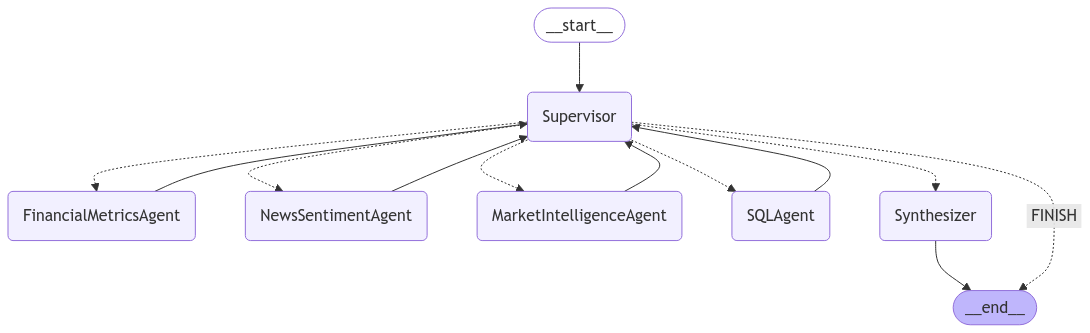

In [149]:
def define_graph():
    """
    Defines and returns a graph representing the financial analysis workflow.
    """
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("FinancialMetricsAgent", financial_metrics_graph)
    workflow.add_node("NewsSentimentAgent", news_sentiment_graph)
    workflow.add_node("Supervisor", supervisor_node)
    workflow.add_node("MarketIntelligenceAgent", market_intelligence_graph)
    
    workflow.add_node("SQLAgent", sql_agent_node)
    
    workflow.add_node("Synthesizer", synthesize_responses)
     # Add Reflection node with retry policy
    # workflow.add_node(
    #     "Reflection", 
    #     #reflection_node
    #     # retry=RetryPolicy(
    #     #     max_attempts=2,
    #     #     retry_on=lambda x: isinstance(x, ValueError) and "Analysis incomplete" in str(x)
    #     # )
    # )
    # Set entry point
    workflow.set_entry_point("Supervisor")
    
    # Define available agents
    members = [
        "FinancialMetricsAgent",
        "NewsSentimentAgent",
        "MarketIntelligenceAgent",
        "SQLAgent"
    ]
    
    # Add edges from agents to Supervisor
    for member in members:
        workflow.add_edge(member, "Supervisor")
    
    # Add edge from Reflection back to Supervisor
    #workflow.add_edge("Reflection", "Supervisor")
    
    # Add conditional routing from Supervisor
    conditional_map = {k: k for k in members}
    #conditional_map["Reflection"] = "Reflection"
    conditional_map["Synthesizer"] = "Synthesizer"
    conditional_map["FINISH"] = END
    
    workflow.add_conditional_edges(
        "Supervisor",
        lambda x: x["next_step"],
        conditional_map
    )
    
    # Add edge from Synthesizer to END
    workflow.add_edge("Synthesizer", END)
    
    return workflow.compile()

fin_agent = define_graph()
display(Image(fin_agent.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [150]:
def test_agent(agent: langgraph.graph.state.CompiledStateGraph, question: str, verbose: bool = True):
    """Run a test query through the agent"""
    callback_handler = CustomConsoleCallbackHandler()
    # callback.verbose = verbose
   
    initial_state = {
        "current_date": datetime.now(),
        "user_input": question,
        "messages": [],
        "next_step": "",
        "config": settings,
        "callback": callback_handler,
        "personality": sample_personality,
        "news_sentiment_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        },
        "financial_metrics_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        },
        "market_intelligence_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        }
    }
    # Run the agent
    response = agent.invoke(initial_state)
    
    return response

In [151]:
response = test_agent(fin_agent, " Should I buys stocks from Pediatrix Medical Group" , verbose = True)


🎯 SUPERVISOR NODE
Current Input:  Should I buys stocks from Pediatrix Medical Group
Analysis Date: 2024-11-30 14:44:55.591433
Personality in supervisor: risk_tolerance=<RiskTolerance.MODERATE: 'moderate'> time_horizon=<TimeHorizon.MEDIUM_TERM: 'medium_term'> investment_style=<InvestmentStyle.BLEND: 'blend'>
Requires historical pre-2023 data consideration: True

=== Supervisor Chain Variables ===
Date Context: 
Current Analysis Date: 2024-11-30 14:44:55 UTC

Team Members:
**1 FinancialMetricsAgent**
Role: Core financial data specialist focusing on company metrics, financial statements, and fundamental analysis.

**2 NewsSentimentAgent**
Role: Specializes in news analysis and sentiment tracking across multiple sources including company-specific news and industry trends.

**3 MarketIntelligenceAgent**
Role: Focuses on market data analysis and insider trading patterns to provide trading insights.

**4 SQLAgent**
Role: Independent LangGraph-based agent specialized in SQL database operation

In [152]:
response.keys()

dict_keys(['current_date', 'user_input', 'messages', 'next_step', 'config', 'callback', 'personality', 'news_sentiment_agent_internal_state', 'financial_metrics_agent_internal_state', 'market_intelligence_agent_internal_state'])

# EVALUATION !

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import wrap

In [167]:
# Function to plot all tools called evaluation
def plot_all_tools_called_eval(response: dict, agent_internal_state: str):
    """
    Creates a visualization of tool usage evaluation results for a specific agent.
    
    This function generates a multi-subplot figure where each subplot represents an iteration
    of tool usage. Each plot shows:
    - Bar chart of tool call counts
    - Error markers and annotations for failed calls
    - Timestamp of iteration
    - Overall tools usage status
    
    Args:
        response (dict): The complete state dictionary from the agent run containing evaluation results.
                        Expected structure:
                        {
                            agent_name: {
                                'all_tools_eval': {
                                    'stats': List[Dict],  # List of iteration statistics
                                    'passed': List[bool]  # List of pass/fail results
                                }
                            }
                        }
        agent_name (str): Name of the agent whose results should be plotted
                         (e.g., 'news_sentiment_agent_internal_state')
    
    Returns:
        None: Displays the plot using plt.show()
    """
     
     # Check if agent's internal state is empty
    all_tools_eval_results = response[agent_internal_state]['all_tools_eval']
    if not all_tools_eval_results['stats']:
        print(f"\n⚠️ No tool evaluation data available for {agent_internal_state}")
        return
    
     # response contains the output state of te Fin agent after a run
    all_tools_eval_results =response[agent_internal_state]['all_tools_eval']

    # Calculate number of iterations and set up the subplots
    n_iterations = len(all_tools_eval_results['stats'])
    fig, axes = plt.subplots(n_iterations, 1, figsize=(12, 5*n_iterations))
    if n_iterations == 1:
        axes = [axes]  # Convert to list for consistent indexing

    # Process each iteration
    for iteration_idx, (ax, iteration_stats) in enumerate(zip(axes, all_tools_eval_results['stats'])):
        # Create DataFrame for this iteration
        tool_counts = iteration_stats['tool_counts']
        
        # Create a mapping of tools to their error messages
        error_messages = {}
        for error in iteration_stats['errors']['execution_errors']:
            tool = error['tool']
            error_msg = error['error'].get('error', str(error['error']))
            error_messages[tool] = error_msg
        
        # Create DataFrame for this iteration
        iteration_data = []
        for tool, count in tool_counts.items():
            has_error = tool in error_messages
            iteration_data.append({
                'Tool': tool,
                'Calls': count,
                'Has Error': has_error,
                'Error Message': error_messages.get(tool, 'No error')
            })
        
        df = pd.DataFrame(iteration_data)
        
        # Create bar plot for this iteration
        sns.barplot(
            data=df,
            x='Tool',
            y='Calls',
            ax=ax,
            color='skyblue'
        )
        
        # Add error markers and annotations
        for idx, row in df.iterrows():
            if row['Has Error']:
                # Plot red X
                ax.plot(
                    idx,
                    row['Calls'],
                    'rx',
                    markersize=10,
                    markeredgewidth=2,
                    label='Error'
                )
                
                # Add error message annotation
                ax.annotate(
                    f"Error: {row['Error Message']}",
                    xy=(idx, row['Calls']),
                    xytext=(10, 10),
                    textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                    fontsize=8,
                    wrap=True
                )
            
            # Add annotation for zero calls
            if row['Calls'] == 0:
                ax.annotate(
                    'Not Called',
                    xy=(idx, 0),
                    xytext=(0, -20),
                    textcoords='offset points',
                    ha='center',
                    va='top',
                    color='red',
                    fontsize=8
                )
        
        # Customize subplot
        ax.set_title(f'Iteration {iteration_idx + 1}', pad=20, size=12)
        ax.set_xlabel('Tools', labelpad=10)
        ax.set_ylabel('Number of Calls', labelpad=10)
        ax.tick_params(axis='x', rotation=45)
        
        # Add timestamp
        timestamp = iteration_stats['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
        ax.text(0.98, 0.98, f'Timestamp: {timestamp}', 
                transform=ax.transAxes, 
                ha='right', 
                va='top', 
                fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.8))
        
        # Add all_tools_used status
        status_text = "✓ All tools used" if iteration_stats['all_tools_used'] else "✗ Not all tools used"
        ax.text(0.02, 0.98, status_text,
                transform=ax.transAxes,
                ha='left',
                va='top',
                fontsize=8,
                color='green' if iteration_stats['all_tools_used'] else 'red',
                bbox=dict(facecolor='white', alpha=0.8))

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return 

def plot_topic_adhrence_eval( response: dict , agent_internal_state = str) :

    """
    Creates a visualization of topic adherence evaluation results for a specific agent.
    
    This function generates a single figure showing the topic adherence evaluation results
    across all iterations. Each iteration is displayed with:
    - Color-coded background (green for pass, red for fail)
    - Iteration number
    - Evaluation status
    - Detailed reason for the evaluation
    
    Args:
        response (dict): The complete state dictionary from the agent run containing evaluation results.
                        Expected structure:
                        {
                            agent_name: {
                                'topic_adherence_eval': {
                                    'passed': List[str],  # List of "true"/"false" strings
                                    'reason': List[str]   # List of evaluation reasons
                                }
                            }
                        }
        agent_name (str): Name of the agent whose results should be plotted
                         (e.g., 'news_sentiment_agent_internal_state')
    
    Returns:
        None: Displays the plot using plt.show()
    """

     # Check if agent's internal state is empty
    topic_adherence_eval_results = response[agent_internal_state]['topic_adherence_eval']
    if not topic_adherence_eval_results['passed']:
        print(f"\n⚠️ No topic adherence evaluation data available for {agent_internal_state}")
        return
    
     # response contains the output state of te Fin agent after a run
    topic_adherence_eval_results =response[agent_internal_state]['topic_adherence_eval']
  
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create data for visualization
    iterations = len(topic_adherence_eval_results['passed'])
    y_positions = range(iterations)

    # Add background colors for each iteration (adjusted height)
    for i, status in enumerate(topic_adherence_eval_results['passed']):
        color = '#ff9999' if status.lower() == 'false' else '#99ff99'
        # Extend the background to fully include the iteration label
        ax.axhspan(i-0.3, i+0.3, color=color, alpha=0.3)

    # Add iteration numbers and evaluation details
    for i, (status, reason) in enumerate(zip(topic_adherence_eval_results['passed'], 
                                        topic_adherence_eval_results['reason'])):
        # Move iteration number inside the colored background
        ax.text(0.02, i, f'Iteration {i+1}:', 
                ha='left', va='center',
                fontsize=11, fontweight='bold')
        
        # Format the reason text (wrap at 70 characters)
        wrapped_reason = '\n'.join(wrap(reason, width=70))
        
        # Create display text with status and reason (moved right to accommodate iteration number)
        display_text = f"Status: {status.upper()}\n{wrapped_reason}"
        
        ax.text(0.15, i, display_text,
                ha='left', va='center',
                fontsize=10,
                color='darkred' if status.lower() == 'false' else 'darkgreen')

    # Customize plot
    ax.set_title('Topic Adherence Evaluation', pad=20, fontsize=14, fontweight='bold')
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.5, iterations-0.5)

    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add a light grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    return

## Market Intelligence Agent

In [168]:
response.keys()

dict_keys(['current_date', 'user_input', 'messages', 'next_step', 'config', 'callback', 'personality', 'news_sentiment_agent_internal_state', 'financial_metrics_agent_internal_state', 'market_intelligence_agent_internal_state'])

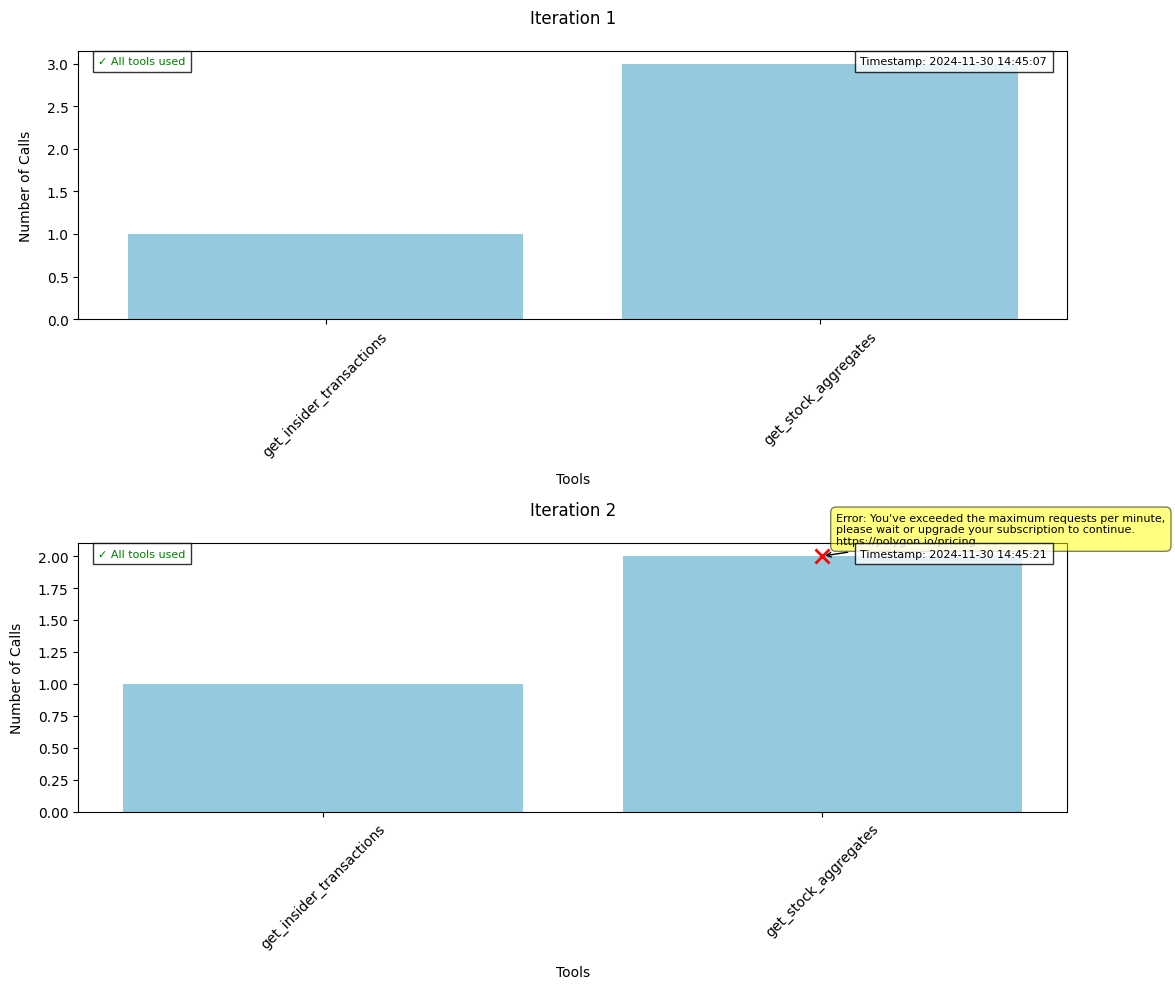

In [169]:
plot_all_tools_called_eval(response, 'market_intelligence_agent_internal_state')

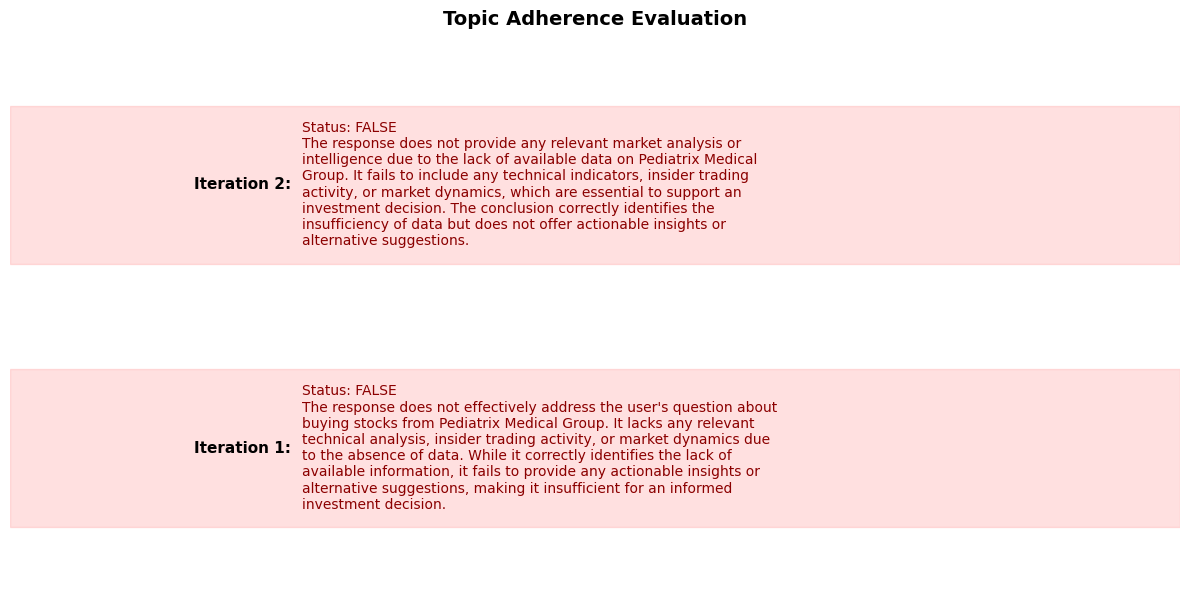

In [170]:
plot_topic_adhrence_eval(response, 'market_intelligence_agent_internal_state')

## Financial Metrics Agent

In [161]:
response['financial_metrics_agent_internal_state']

{'agent_executor_tools': {},
 'full_response': {},
 'all_tools_eval': {'stats': [], 'passed': []},
 'topic_adherence_eval': {'passed': [], 'reason': []}}

In [171]:
plot_all_tools_called_eval(response, 'financial_metrics_agent_internal_state')


⚠️ No tool evaluation data available for financial_metrics_agent_internal_state


In [172]:
plot_topic_adhrence_eval(response, 'financial_metrics_agent_internal_state')


⚠️ No topic adherence evaluation data available for financial_metrics_agent_internal_state


## News Sentiment Agent

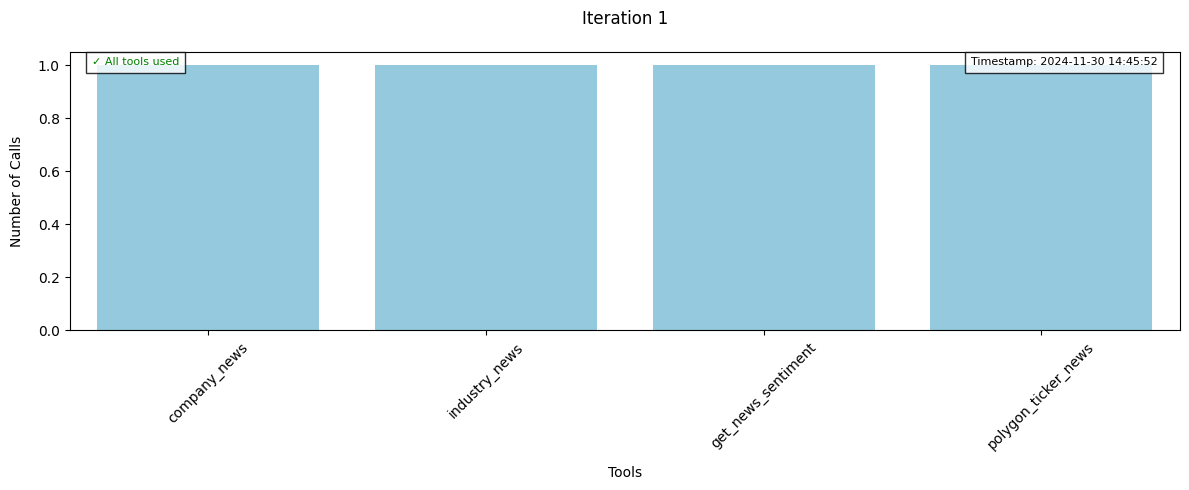

In [173]:
plot_all_tools_called_eval(response, 'news_sentiment_agent_internal_state')

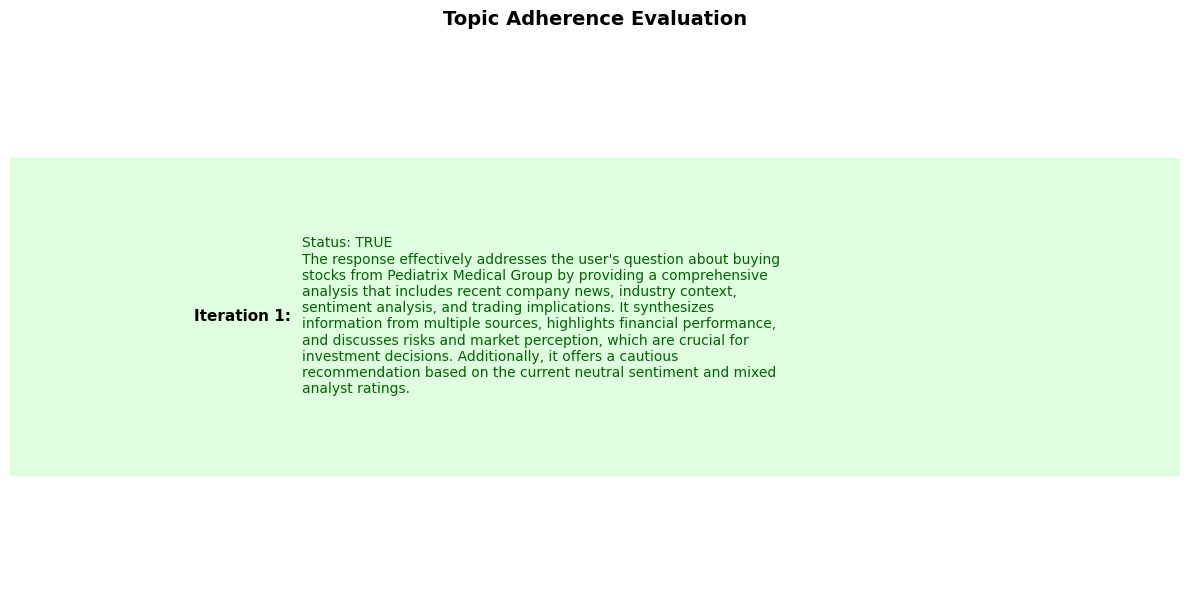

In [174]:
plot_topic_adhrence_eval(response, 'news_sentiment_agent_internal_state')